## Cost Explorer

Each data science project and its resources are labeled with the `CostCenter` tag. The value of the tag is entered by the Data Science Admin during project creation stage in SageMaker Studio. Tags allow to organize the resources and [track AWS costs](https://docs.aws.amazon.com/awsaccountbilling/latest/aboutv2/cost-alloc-tags.html) on a detailed level. In order to see the costs associated with the project, one needs to activate the cost allocation tags. This section describes how to activate the cost allocation tags, enable the cost explorer and track costs daily by service using [boto3 for Cost Explorer](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/ce.html).

To perform these steps log into AWS Console with the Full Stack Developer role. Follow the [AWS console](https://signin.aws.amazon.com/switchrole) link to assume the Full Stack Developer role. The role has been created for you during the deployment. The role name has the following pattern:  **region-full-stack-developer-account_id**. You might find it helpful to first navigate to IAM in AWS Console in order to retrieve the role name and assume it using [AWS console](https://signin.aws.amazon.com/switchrole) link.


### How to Enable Cost Allocation Tags

Please note, that it takes 24 hours before the tags are activated.

1. Click on your account name in the upper right corner and then click on `Billing Dashboard`. On the left hand panel under `Billing` click on `Cost allocation tags`. 

![billing_dashboard](images/cost_explorer/billing_dashboard.png)

2. Under `User-Defined Cost Allocation Tags` section, select your tags and click the `Activate` button.

![cost_allocation_tag](images/cost_explorer/cost_allocation_tag.png)

### How to Enable Cost Explorer 

1. Open [AWS Cost Management console](https://console.aws.amazon.com/cost-management/home).

2. On the left side panel choose `Cost Explorer`.

3. On the `Welcome to Cost Explorer` page, choose `Launch Cost Explorer`.

4. **Wait for 24 hours.**

5. Explore costs associated with different `Tags` in the AWS Console

![cost_explorer](images/cost_explorer/cost_explorer_tag.png)

### Boto3 SDK

In this section we will demonstrate how to retrieve the costs by service using [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/ce.html) and visualize them as bar plot using [matplotlib library](https://matplotlib.org/).

Load the Python modules and call boto3 client for the cost explorer.

In [1]:
import boto3
import datetime

client = boto3.client("ce")

Define the time period for which you want to retrieve the costs.

In [2]:
start, end = "2022-05-27", "2022-06-06"

Retrieve the cost and usage, filter by the user-defined cost allocation tags. Here we obtain daily results.

In [3]:
response = client.get_cost_and_usage(
    TimePeriod={"Start": start, "End": end},
    Granularity="DAILY",
    Filter={
        "Tags": {
            "Key": "CostCenter",
            "Values": ["12345"],
        },
        "Tags": {
            "Key": "sagemaker:project-name",
            "Values": ["again-mlops"],
        },
    },
    Metrics=["AmortizedCost"],
    GroupBy=[
        {"Type": "DIMENSION", "Key": "SERVICE"},
    ],
)

Process the `response` to prepare the data for visualization.

In [4]:
cost_explorer = []
timestamps = []
for time in response["ResultsByTime"]:
    log = {}
    timestamp = time["TimePeriod"]["Start"]
    log["timestamp"] = timestamp
    for json_key in time["Groups"]:
        service, cost = (
            json_key["Keys"][0],
            float(json_key["Metrics"]["AmortizedCost"]["Amount"]),
        )
        log[service] = cost
    cost_explorer.append(log)
    timestamps.append(timestamp)
cost_explorer

[{'timestamp': '2022-05-27'},
 {'timestamp': '2022-05-28'},
 {'timestamp': '2022-05-29'},
 {'timestamp': '2022-05-30'},
 {'timestamp': '2022-05-31'},
 {'timestamp': '2022-06-01'},
 {'timestamp': '2022-06-02'},
 {'timestamp': '2022-06-03',
  'AWS Key Management Service': 0.0305555558,
  'Amazon Simple Storage Service': 0.0002321948},
 {'timestamp': '2022-06-04',
  'AWS Key Management Service': 0.0333333336,
  'Amazon Simple Storage Service': 4.5992e-06},
 {'timestamp': '2022-06-05',
  'AWS Key Management Service': 0.0333333336,
  'Amazon Simple Storage Service': 4.5992e-06}]

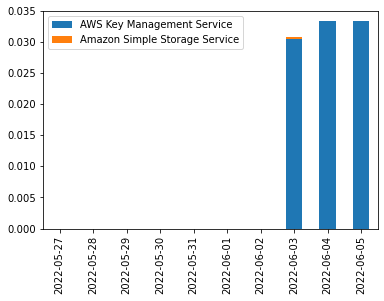

In [5]:
import pandas as pd

pd.DataFrame(cost_explorer, index=timestamps).drop("timestamp", axis=1).fillna(
    value=0
).plot(kind="bar", stacked=True);